In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


image_dir = '/kaggle/input/flood-area-segmentation/Image'

image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]



mask_dir = '/kaggle/input/flood-area-segmentation/Mask'

mask_paths = [os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir) if mask.endswith(('.jpg', '.png', '.jpeg'))]

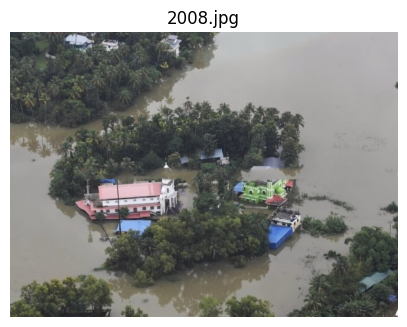

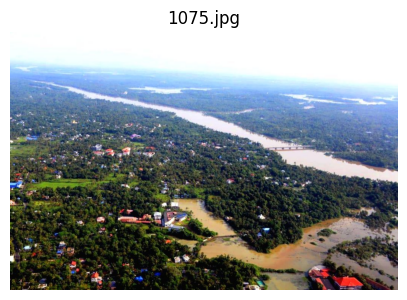

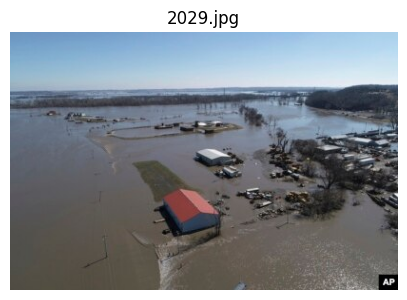

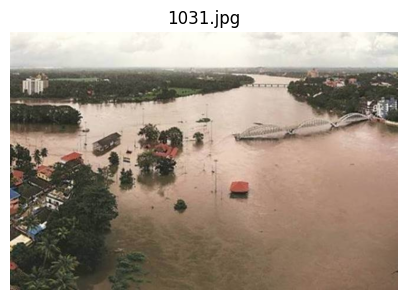

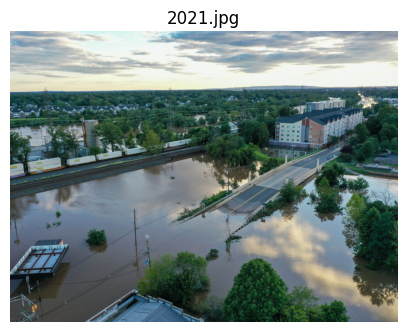

In [4]:
def display_images(image_paths,count):
    for i, image_path in enumerate(image_paths):
        image_name = os.path.basename(image_path)
        if count==i:
            break
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error loading image: {image_path}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"{image_name}")
        plt.axis('off')
        plt.show()

display_images(image_paths,5)

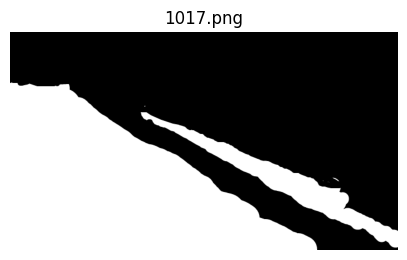

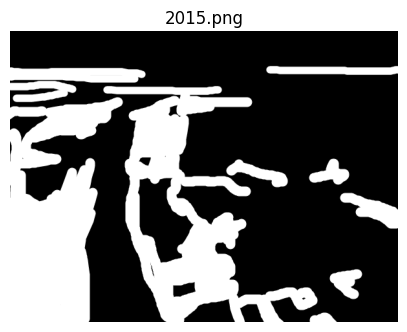

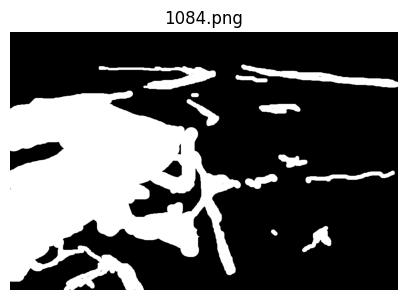

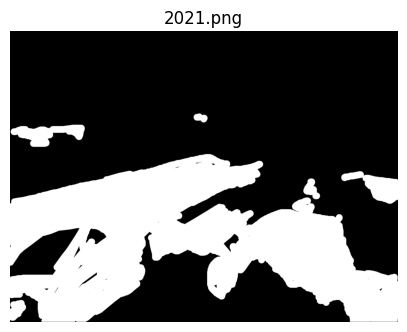

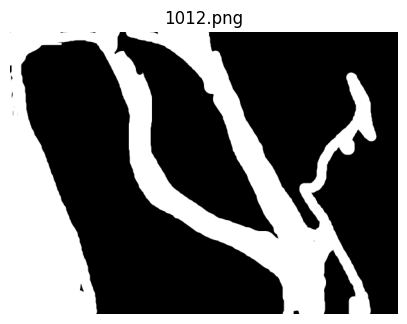

In [5]:
def display_masks(mask_paths, count):

    for i, mask_path in enumerate(mask_paths):
        mask_name = os.path.basename(mask_path)
        if i >= count:
            break
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

        if mask is None:
            print(f"Error loading mask: {mask_path}")
            continue

        plt.figure(figsize=(5, 5))
        plt.imshow(mask, cmap='gray')
        plt.title(f"{mask_name}")
        plt.axis('off')
        plt.show()

display_masks(mask_paths, 5)


In [6]:
def segment_image_kmeans(image_path, k=3):
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixel_values = image_rgb.reshape((-1, 3))

    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)

    segmented_image = centers[labels.flatten()]

    segmented_image = segmented_image.reshape(image_rgb.shape)

    return segmented_image

In [7]:
def save_segmented_image(segmented_image, original_image_path, output_folder="SegmentedImages"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_name = os.path.basename(original_image_path)
    save_path = os.path.join(output_folder,image_name)

    segmented_image_bgr = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, segmented_image_bgr)

    print(f"Segmented image saved at: {save_path}")

In [8]:
def segment_and_save_images(image_paths,k):
    for i, image_path in enumerate(image_paths):
        image_name = os.path.basename(image_path)

        segmented_image = segment_image_kmeans(image_path, k)

        if segmented_image is not None:
            save_segmented_image(segmented_image, image_path)
    

In [ ]:
segment_and_save_images(image_paths,3)

Segmented image saved at: SegmentedImages/2008.jpg
Segmented image saved at: SegmentedImages/1075.jpg
Segmented image saved at: SegmentedImages/2029.jpg
Segmented image saved at: SegmentedImages/1031.jpg
Segmented image saved at: SegmentedImages/2021.jpg
Segmented image saved at: SegmentedImages/1024.jpg
Segmented image saved at: SegmentedImages/3014.jpg
Segmented image saved at: SegmentedImages/45.jpg
Segmented image saved at: SegmentedImages/20.jpg
Segmented image saved at: SegmentedImages/1009.jpg
Segmented image saved at: SegmentedImages/2028.jpg
Segmented image saved at: SegmentedImages/6.jpg
Segmented image saved at: SegmentedImages/2041.jpg
Segmented image saved at: SegmentedImages/2003.jpg
Segmented image saved at: SegmentedImages/1055.jpg
Segmented image saved at: SegmentedImages/1026.jpg
Segmented image saved at: SegmentedImages/3064.jpg
Segmented image saved at: SegmentedImages/1010.jpg
Segmented image saved at: SegmentedImages/1025.jpg
Segmented image saved at: SegmentedIma

In [ ]:
seg_dir = '/kaggle/working/SegmentedImages'

seg_paths = [os.path.join(seg_dir, seg) for seg in os.listdir(seg_dir) if seg.endswith(('.jpg', '.png', '.jpeg'))]

def display_segs(seg_paths, count):

    for i, seg_path in enumerate(seg_paths):
        seg_name = os.path.basename(seg_path)
        if i >= count:
            break
        seg = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)  

        if seg is None:
            print(f"Error loading mask: {seg_path}")
            continue

        plt.figure(figsize=(5, 5))
        plt.imshow(seg, cmap='gray')
        plt.title(f"{seg_name}")
        plt.axis('off')
        plt.show()

display_segs(seg_paths, 5)

In [ ]:
def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    dice_score = (2 * np.sum(intersection)) / (np.sum(predicted_mask) + np.sum(ground_truth_mask))
    return dice_score

def calculate_pixel_accuracy(predicted_mask, ground_truth_mask):
    correct = np.sum(predicted_mask == ground_truth_mask)
    total = predicted_mask.size
    accuracy = correct / total
    return accuracy

In [ ]:
iou_scores = []
dice_scores = []
accuracies = []

for mask_filename in os.listdir(mask_dir):

    if not mask_filename.endswith(".png"):
        continue
    
    mask_path = os.path.join(mask_dir, mask_filename)
    
    segmented_filename = mask_filename.replace(".png", ".jpg")
    segmented_path = os.path.join(seg_dir, segmented_filename)
    
    if not os.path.exists(segmented_path):
        continue

    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    segmented_image = cv2.imread(segmented_path, cv2.IMREAD_GRAYSCALE)
    segmented_image_resized = cv2.resize(segmented_image, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    _, ground_truth_binary = cv2.threshold(ground_truth_mask, 127, 1, cv2.THRESH_BINARY)
    _, segmented_binary = cv2.threshold(segmented_image_resized, 127, 1, cv2.THRESH_BINARY)

    iou = calculate_iou(segmented_binary, ground_truth_binary)
    dice = calculate_dice(segmented_binary, ground_truth_binary)
    accuracy = calculate_pixel_accuracy(segmented_binary, ground_truth_binary)

    iou_scores.append(iou)
    dice_scores.append(dice)
    accuracies.append(accuracy)

In [ ]:
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)
avg_accuracy = np.mean(accuracies)

print("\nSummary of Results:")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average Pixel Accuracy: {avg_accuracy:.4f}")

In [ ]:
def segment_image_kmeans_with_pca(image_path, k=3, n_components=2):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_values = image_rgb.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    pca = PCA(n_components=n_components)
    reduced_pixels = pca.fit_transform(pixel_values)

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
    labels = kmeans.fit_predict(reduced_pixels)
    centers = kmeans.cluster_centers_

    centers = pca.inverse_transform(centers)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image_rgb.shape)

    return segmented_image

In [ ]:
iou_scores_pca = []
dice_scores_pca = []
accuracies_pca = []

for mask_filename in os.listdir(mask_folder):
    if not mask_filename.endswith(".png"):
        continue
    
    mask_path = os.path.join(mask_dir, mask_filename)
    segmented_path = os.path.join(segmented_folder, mask_filename.replace(".png", ".jpg"))
    
    if not os.path.exists(segmented_path):
        continue
    
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    segmented_image_pca = segment_image_kmeans_with_pca(segmented_path, k=3, n_components=2)
    
    if segmented_image_pca is None:
        continue
    
    segmented_gray_pca = cv2.cvtColor(segmented_image_pca, cv2.COLOR_RGB2GRAY)
    _, segmented_binary_pca = cv2.threshold(segmented_gray_pca, 127, 1, cv2.THRESH_BINARY)
    _, ground_truth_binary = cv2.threshold(ground_truth_mask, 127, 1, cv2.THRESH_BINARY)
    
    segmented_binary_pca_resized = cv2.resize(segmented_binary_pca, 
                                          (ground_truth_binary.shape[1], ground_truth_binary.shape[0]), 
                                          interpolation=cv2.INTER_NEAREST)

    iou_pca = calculate_iou(segmented_binary_pca_resized, ground_truth_binary)
    dice_pca = calculate_dice(segmented_binary_pca_resized, ground_truth_binary)
    accuracy_pca = calculate_pixel_accuracy(segmented_binary_pca_resized, ground_truth_binary)
    
    iou_scores_pca.append(iou_pca)
    dice_scores_pca.append(dice_pca)
    accuracies_pca.append(accuracy_pca)

In [ ]:
avg_iou_pca = np.mean(iou_scores_pca)
avg_dice_pca = np.mean(dice_scores_pca)
avg_accuracy_pca = np.mean(accuracies_pca)

print("\nSummary of Results with PCA:")
print(f"Average IoU (with PCA): {avg_iou_pca:.4f}")
print(f"Average Dice Score (with PCA): {avg_dice_pca:.4f}")
print(f"Average Pixel Accuracy (with PCA): {avg_accuracy_pca:.4f}")

In [ ]:
avg_metrics_original = [np.mean(iou_scores), np.mean(dice_scores), np.mean(accuracies)]
avg_metrics_pca = [np.mean(iou_scores_pca), np.mean(dice_scores_pca), np.mean(accuracies_pca)]
metrics_labels = ["IoU", "Dice Score", "Pixel Accuracy"]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=metrics_labels,
    y=avg_metrics_original,
    name='Original Segmentation',
    marker_color='black'
))

fig.add_trace(go.Bar(
    x=metrics_labels,
    y=avg_metrics_pca,
    name='PCA Segmentation',
    marker_color='red'
))

fig.update_layout(
    title="Average Performance Comparison between Original and PCA Segmentation",
    xaxis_title="Metrics",
    yaxis_title="Average Score",
    barmode='group',
    height=500
)

fig.show()